# Model to predict a readability score from text

Most of the features extracted manually comes from [ReadNet: A Hierarchical Transformer Framework for Readability Analysis](https://arxiv.org/pdf/2103.04083v1.pdf)

In [53]:
train_filepath = 'inputs/train.csv'
test_filepath = 'inputs/test.csv'
output_filepath = 'outputs/submission.csv'

# I'm using the ngrams available in https://github.com/hackerb9/gwordlist
unigram_url = 'https://raw.githubusercontent.com/hackerb9/gwordlist/master/frequency-alpha-gcide.txt'

In [2]:
import pandas as pd
train_data = pd.read_csv(train_filepath)

In [3]:
raw_unigrams = pd.read_csv(unigram_url, sep='\t')
raw_unigrams.columns = ['gold_content', 'count', 'percent', 'cumulative']
unigrams = pd.DataFrame(raw_unigrams.gold_content.str.split(' ', 1).tolist(),
                                 columns = ['ranking','unigram'])
unigrams['unigram'] = unigrams['unigram'].str.strip()
unigrams['ranking'] = pd.to_numeric(unigrams["ranking"])
unigrams_dict = dict(zip(unigrams['unigram'], unigrams['ranking']))
unigrams

,ranking,unigram
0,1,the
1,2,of
2,3,and
3,4,to
4,5,in
...,...,...
65532,65533,nitrifier
65533,65534,fordo
65534,65535,elusory
65535,65536,foamless


## Extract manual features

In [4]:
from spacy_syllables import SpacySyllables
import spacy

nlp = spacy.load("en_core_web_lg")
nlp.add_pipe("syllables", after="tagger")

In [147]:
def get_features(text):
    doc = nlp(text)
    
    features = {}
    character_counter = []
    syllables_counter = []
    difficult_counter = []
    num_pronouns = 0
    num_long_words = 0
    num_sentences = len(list(doc.sents))
    num_difficult_words = 0
    num_words = len(doc)
    embedding_size = 32
    chunk_size = int(num_words / embedding_size)
    window_data = []

    words = []
    for index, token in enumerate(doc):
        
        # Building the difficulty embedding
        """
        if (index + 1) % chunk_size == 0 and (index + 1) / chunk_size < 33:
            if len(window_data) > 0:
                features[f'difficult_pooling_{int((index + 1) / chunk_size)}'] = min(window_data)
            else:
                features[f'difficult_pooling_{int((index + 1) / chunk_size)}'] = 1.0
            window_data = []
        """
        
        character_counter.append(len(token.text))
        if token._.syllables_count:
            syllables_counter.append(token._.syllables_count)
        words.append(token.text)
        if token.pos_ == 'PRON':
            num_pronouns += 1
        if len(token.text) > 6:
            num_long_words += 1
        word_difficulty = unigrams_dict.get(token.text, 65538)
        if len(token.text) > 1 and word_difficulty > 4000:
            num_difficult_words += 1
        # Assumption 1 letter words are pretty common: a , . : !
        if len(token.text) > 1 and word_difficulty < 65538:
            difficult_counter.append(1 / word_difficulty)
            window_data.append(1 / word_difficulty)
            
    # ------- Sentence level features ---------
    # Characters per word
    features['avg_chars_per_word'] = sum(character_counter) / len(character_counter)
    features['max_chars_per_word'] = max(character_counter)
    # Syllabi per word
    features['avg_syllables_per_word'] = sum(syllables_counter) / len(syllables_counter)
    features['max_syllables_per_word'] = max(syllables_counter)
    # words
    features['num_words'] = len(words)
    # long words > 6 letters
    features['num_long_words'] = num_long_words
    # difficult words
    features['num_difficult_words'] = num_difficult_words
    # pronouns
    features['num_pronouns'] = num_pronouns

    # ------- Document level features ----------
    features['words_by_sentence'] = len(words) / num_sentences
    features['syllables_by_word'] = sum(syllables_counter) / len(words)
    features['characters_by_word'] = len(text) / len(words)
    features['letters_by_word'] = sum(character_counter) / len(words)
    features['long_words_by_word'] = num_long_words / len(words)
    features['unique_words_by_word'] = len(set(words)) / len(words)
    features['difficult_words_by_word'] = num_difficult_words / len(words)

    # -------- Dificulty of the words ----------
    features['avg_difficulty'] = sum(difficult_counter) / len(difficult_counter)

    # Embedding of the most difficult words
    most_difficult_words = difficult_counter
    most_difficult_words.sort()
    most_difficult_words = list(set(most_difficult_words))
    most_difficult_words.sort()
    for index in range(24):
        features[f'difficult_word_{index}'] = most_difficult_words[index]

    return features

sample_text = 'The commutator is peculiar, consisting of only three segments of a copper ring, while in the simplest of other continuous current generators several times that number exist, and frequently 120! segments are to be found. These three segments are made so as to be removable in a moment for cleaning or replacement. They are mounted upon a metal support, and are surrounded on all sides by a free air space, and cannot, therefore, lose their insulated condition. This feature of air insulation is peculiar to this system, and is very important as a factor in the durability of the commutator. Besides this, the commutator is sustained by supports carried in flanges upon the shaft, which flanges, as an additional safeguard, are coated all over with hard rubber, one of the finest known insulators. It may be stated, without fear of contradiction, that no other commutator made is so thoroughly insulated and protected. The three commutator segments virtually constitute a single copper ring, mounted in free air, and cut into three equal pieces by slots across its face.'
features = get_features(sample_text)
features

{'avg_chars_per_word': 4.394088669950739,
 'max_chars_per_word': 13,
 'avg_syllables_per_word': 1.6045197740112995,
 'max_syllables_per_word': 4,
 'num_words': 203,
 'num_long_words': 48,
 'num_difficult_words': 37,
 'num_pronouns': 4,
 'words_by_sentence': 25.375,
 'syllables_by_word': 1.3990147783251232,
 'characters_by_word': 5.261083743842365,
 'letters_by_word': 4.394088669950739,
 'long_words_by_word': 0.23645320197044334,
 'unique_words_by_word': 0.5566502463054187,
 'difficult_words_by_word': 0.18226600985221675,
 'avg_difficulty': 0.10670509923036829,
 'difficult_word_0': 5.229031583350764e-05,
 'difficult_word_1': 6.813381481229134e-05,
 'difficult_word_2': 8.59697386519945e-05,
 'difficult_word_3': 9.858044164037855e-05,
 'difficult_word_4': 0.00012319822594554638,
 'difficult_word_5': 0.00012495314257153568,
 'difficult_word_6': 0.00014461315979754158,
 'difficult_word_7': 0.0001966955153422502,
 'difficult_word_8': 0.00020247013565499088,
 'difficult_word_9': 0.00022202486

## Training dataset

We build a new dataset using manual features defined above. 

In [148]:
import pandas as pd

new_dataset = []
labels = []
for item in train_data.to_dict('records'):
    features = get_features(item['excerpt'])
    new_dataset.append(features)
    labels.append(item['target'])

new_dataset = pd.DataFrame(new_dataset)
new_dataset

,avg_chars_per_word,max_chars_per_word,avg_syllables_per_word,max_syllables_per_word,num_words,num_long_words,num_difficult_words,num_pronouns,words_by_sentence,syllables_by_word,...,difficult_word_14,difficult_word_15,difficult_word_16,difficult_word_17,difficult_word_18,difficult_word_19,difficult_word_20,difficult_word_21,difficult_word_22,difficult_word_23
0,3.845070,10,1.281768,4,213,30,44,4,14.200000,1.089202,...,0.000299,0.000306,0.000324,0.000348,0.000360,0.000377,0.000390,0.000401,0.000410,0.000420
1,3.394737,11,1.335329,4,228,26,41,29,14.250000,0.978070,...,0.000291,0.000303,0.000310,0.000338,0.000380,0.000402,0.000415,0.000443,0.000445,0.000448
2,3.426606,10,1.257485,3,218,25,42,23,19.818182,0.963303,...,0.000461,0.000484,0.000486,0.000495,0.000508,0.000557,0.000761,0.000805,0.000812,0.000833
3,3.716418,12,1.185629,3,201,22,43,12,33.500000,0.985075,...,0.000193,0.000212,0.000283,0.000304,0.000316,0.000330,0.000331,0.000351,0.000355,0.000391
4,3.153005,8,1.125828,3,183,2,48,9,36.600000,0.928962,...,0.008696,0.009009,0.009259,0.016667,0.017857,0.019608,0.020833,0.025000,0.029412,0.030303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,4.412791,15,1.400000,6,172,34,53,9,12.285714,1.180233,...,0.001056,0.001078,0.001095,0.001161,0.001190,0.001279,0.001605,0.001686,0.001745,0.001996
2830,3.956522,15,1.323171,5,184,21,38,12,12.266667,1.179348,...,0.000389,0.000463,0.000472,0.000688,0.000794,0.000854,0.000911,0.001026,0.001182,0.001215
2831,3.506912,14,1.282723,5,217,21,31,14,12.764706,1.129032,...,0.000792,0.000854,0.001022,0.001054,0.001453,0.001570,0.001590,0.001647,0.001764,0.001876
2832,3.813830,14,1.281046,4,188,20,39,9,13.428571,1.042553,...,0.000656,0.000688,0.000704,0.000707,0.000714,0.000737,0.001048,0.001049,0.001070,0.001138


Split the dataset in training and validation set

In [149]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    new_dataset, labels, test_size=0.2, random_state=42)
X_val1, X_val2, y_val1, y_val2 = train_test_split(
    X_val, y_val, test_size=0.5, random_state=42)

## Oversampling training data

In [114]:
"""
custom_columns = X_train.columns
X_train = X_train.copy()
X_train['target'] = y_train

corr = X_train.corr()

oversampled_data = []
for item in X_train.to_dict('records'):
    if item['target'] > -0.202540:
        item['target'] -= 0.47
        oversampled_data.append(item)
    else:
        oversampled_data.append(item)
        
    elif item['target'] < -1.690320:
        item['target'] += 0.6
        oversampled_data.append(item)

# Shuffle the data
oversampled_data = pd.DataFrame(oversampled_data)
oversampled_data = oversampled_data.sample(frac=1.0)
X_train = oversampled_data[custom_columns]
y_train = oversampled_data['target']

corr.style.background_gradient(cmap='coolwarm').set_precision(2)
"""

,avg_chars_per_word,max_chars_per_word,avg_syllables_per_word,max_syllables_per_word,num_words,num_long_words,num_difficult_words,num_pronouns,words_by_sentence,syllables_by_word,characters_by_word,letters_by_word,long_words_by_word,unique_words_by_word,difficult_words_by_word,avg_difficulty,difficult_word_0,difficult_word_1,difficult_word_2,difficult_word_3,difficult_word_4,difficult_word_5,difficult_word_6,difficult_word_7,difficult_word_8,difficult_word_9,difficult_word_10,difficult_word_11,difficult_word_12,difficult_word_13,difficult_word_14,difficult_word_15,difficult_word_16,difficult_word_17,difficult_word_18,difficult_word_19,difficult_word_20,difficult_word_21,difficult_word_22,difficult_word_23,target
avg_chars_per_word,1.00,0.62,0.90,0.63,-0.29,0.89,0.25,-0.68,0.20,0.95,1.00,1.00,0.94,0.38,0.39,0.24,0.01,0.01,-0.01,-0.02,-0.04,-0.04,-0.06,-0.06,-0.07,-0.08,-0.08,-0.09,-0.09,-0.10,-0.11,-0.11,-0.12,-0.12,-0.11,-0.11,-0.11,-0.12,-0.10,-0.09,-0.46
max_chars_per_word,0.62,1.00,0.62,0.70,-0.08,0.60,0.13,-0.39,0.15,0.62,0.61,0.62,0.61,0.27,0.18,0.12,-0.04,-0.05,-0.05,-0.06,-0.07,-0.07,-0.08,-0.09,-0.09,-0.09,-0.09,-0.10,-0.10,-0.11,-0.12,-0.12,-0.12,-0.12,-0.11,-0.11,-0.11,-0.11,-0.10,-0.10,-0.40
avg_syllables_per_word,0.90,0.62,1.00,0.66,-0.17,0.90,0.28,-0.64,0.13,0.94,0.88,0.90,0.93,0.23,0.37,0.16,0.03,0.04,0.04,0.03,0.01,0.01,-0.01,-0.01,-0.02,-0.02,-0.03,-0.04,-0.05,-0.06,-0.06,-0.06,-0.06,-0.06,-0.06,-0.06,-0.06,-0.06,-0.05,-0.04,-0.47
max_syllables_per_word,0.63,0.70,0.66,1.00,-0.08,0.63,0.13,-0.41,0.17,0.66,0.63,0.63,0.63,0.24,0.17,0.14,-0.05,-0.05,-0.05,-0.06,-0.06,-0.07,-0.08,-0.08,-0.09,-0.09,-0.09,-0.09,-0.10,-0.11,-0.11,-0.11,-0.11,-0.11,-0.10,-0.10,-0.10,-0.11,-0.09,-0.09,-0.42
num_words,-0.29,-0.08,-0.17,-0.08,1.00,0.03,0.36,0.33,-0.16,-0.29,-0.31,-0.29,-0.21,-0.38,-0.02,-0.12,-0.10,-0.11,-0.11,-0.11,-0.11,-0.12,-0.12,-0.13,-0.12,-0.14,-0.15,-0.15,-0.14,-0.14,-0.14,-0.14,-0.15,-0.11,-0.09,-0.09,-0.08,-0.09,-0.09,-0.09,-0.01
num_long_words,0.89,0.60,0.90,0.63,0.03,1.00,0.36,-0.56,0.14,0.86,0.87,0.89,0.97,0.24,0.38,0.18,-0.04,-0.05,-0.06,-0.07,-0.09,-0.09,-0.11,-0.12,-0.12,-0.12,-0.13,-0.14,-0.14,-0.15,-0.15,-0.15,-0.16,-0.14,-0.13,-0.13,-0.13,-0.13,-0.12,-0.11,-0.51
num_difficult_words,0.25,0.13,0.28,0.13,0.36,0.36,1.00,-0.27,-0.29,0.13,0.21,0.25,0.27,-0.08,0.92,0.18,-0.08,-0.10,-0.14,-0.14,-0.14,-0.14,-0.14,-0.14,-0.13,-0.13,-0.12,-0.10,-0.08,-0.07,-0.06,-0.05,-0.05,-0.01,0.01,0.02,0.02,0.02,0.03,0.04,-0.14
num_pronouns,-0.68,-0.39,-0.64,-0.41,0.33,-0.56,-0.27,1.00,-0.15,-0.63,-0.67,-0.68,-0.62,-0.17,-0.43,-0.45,-0.05,-0.06,-0.05,-0.04,-0.03,-0.04,-0.03,-0.03,-0.02,-0.02,-0.02,-0.02,-0.02,-0.01,-0.01,-0.02,-0.01,-0.01,-0.01,-0.01,-0.01,-0.00,-0.02,-0.02,0.35
words_by_sentence,0.20,0.15,0.13,0.17,-0.16,0.14,-0.29,-0.15,1.00,0.22,0.22,0.20,0.17,0.26,-0.24,0.21,-0.12,-0.14,-0.14,-0.15,-0.17,-0.17,-0.17,-0.17,-0.17,-0.18,-0.17,-0.16,-0.15,-0.14,-0.15,-0.15,-0.15,-0.11,-0.10,-0.11,-0.10,-0.10,-0.08,-0.07,-0.37
syllables_by_word,0.95,0.62,0.94,0.66,-0.29,0.86,0.13,-0.63,0.22,1.00,0.95,0.95,0.92,0.32,0.26,0.21,0.02,0.03,0.02,0.01,-0.00,-0.01,-0.03,-0.03,-0.04,-0.04,-0.05,-0.06,-0.07,-0.08,-0.08,-0.08,-0.09,-0.10,-0.10,-0.10,-0.10,-0.11,-0.09,-0.09,-0.47


## Defining the models

In [144]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

models = {}
models['LinearRegression'] = LinearRegression()
models['Ridge'] = Ridge()
models['Lasso'] = Lasso()
models['BayesianRidge'] = BayesianRidge()
models['SVR'] = SVR()
models['KNeighborsRegressor'] = KNeighborsRegressor()
models['GradientBoostingRegressor'] = GradientBoostingRegressor()
models['RandomForestRegressor'] = RandomForestRegressor()

## Training the models

In [150]:
from sklearn.metrics import mean_squared_error

prediction_map = {}
for model_name in models:
    models[model_name].fit(X_train, y_train)
    predictions = models[model_name].predict(X_val1)
    prediction_map[model_name] = predictions

    rmse = mean_squared_error(y_val1, predictions, squared=False)
    print(f'Model: {model_name}')
    print(f'RMSE: {rmse}')

print('--------------------------------')
# Build stack_data
stack_data = pd.DataFrame(prediction_map)

stack_model = LinearRegression()
stack_model.fit(stack_data, y_val1)

# Build stack_data for predictions
prediction_map = {}
for model_name in models:
    prediction_map[model_name] = models[model_name].predict(X_val2)
    rmse = mean_squared_error(y_val2, prediction_map[model_name], squared=False)
    print(f'Model: {model_name}')
    print(f'RMSE: {rmse}')
stack_data_val = pd.DataFrame(prediction_map)

predictions = stack_model.predict(stack_data_val)
rmse = mean_squared_error(y_val2, predictions, squared=False)
print('Model: Stack Model')
print(F'RMSE: {rmse}')

Model: LinearRegression
RMSE: 0.8056272840991245
Model: Ridge
RMSE: 0.8189693767939559
Model: Lasso
RMSE: 0.8650127064863393
Model: BayesianRidge
RMSE: 0.8174183140339027
Model: SVR
RMSE: 0.8427631160667949
Model: KNeighborsRegressor
RMSE: 0.8828129044382291
Model: GradientBoostingRegressor
RMSE: 0.7669039976095813
Model: RandomForestRegressor
RMSE: 0.7833732986192553
--------------------------------
Model: LinearRegression
RMSE: 0.8049807370814616
Model: Ridge
RMSE: 0.8121924851618574
Model: Lasso
RMSE: 0.8353155938207547
Model: BayesianRidge
RMSE: 0.8127032579020272
Model: SVR
RMSE: 0.8246413865556451
Model: KNeighborsRegressor
RMSE: 0.8669536771963422
Model: GradientBoostingRegressor
RMSE: 0.7893140342618709
Model: RandomForestRegressor
RMSE: 0.7966612618838717
Model: Stack Model
RMSE: 0.8016139816658331


## Error Analysis

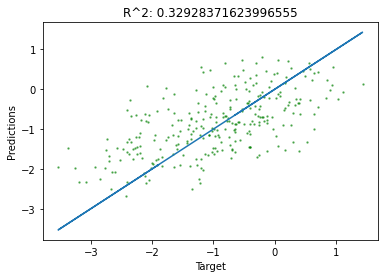

In [151]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

plt.scatter(y_val2, predictions, s=2, c='g', alpha=0.5)
plt.plot(y_val2, y_val2)
plt.xlabel("Target")
plt.ylabel("Predictions")
plt.title(f'R^2: {r2_score(y_val2, predictions)}')
plt.show()

## Saving the predictions

In [58]:
test_data = pd.read_csv(test_filepath)

test_dataset = []
identifiers = []
for item in test_data.to_dict('records'):
    features = get_features(item['excerpt'])
    identifiers.append(item['id'])
    test_dataset.append(features)

test_dataset = pd.DataFrame(test_dataset)

# Build stack_data for predictions
prediction_map = {}
for model_name in models:
    prediction_map[model_name] = models[model_name].predict(test_dataset)
stack_data_test = pd.DataFrame(prediction_map)

test_predictions = stack_model.predict(stack_data_test)
result = pd.DataFrame({'id': identifiers, 'target': test_predictions})
result.to_csv(output_filepath, index=False)